<a href="https://colab.research.google.com/github/djinnome/pgmpy/blob/dev/MLSS_Africa_Structural_Causal_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Causal Inference Practical from MLSS Africa 2019

This is a cleaned-up version of the jupyter notebook created for the Causal Inference practical at MLSS Africa 2019, created by Ferenc Huszár. This complements additional resources on introducing causal inference to an ML audience:
* MLSS 2019 lectures, available on youtube: [Part 1](https://www.youtube.com/watch?v=HOgx_SBBzn0), [Part2](https://www.youtube.com/watch?v=_RtxTpOb8e4)
* MLSS 2019 practical session, going through this notebook: [YouTube link](https://www.youtube.com/watch?v=evmGGusk6gg)
* Blog post series on Causal Inference: [Part 1: do calculus](https://www.inference.vc/untitled/) ,[Part 2: Three scripts toy example](https://www.inference.vc/causal-inference-2-illustrating-interventions-in-a-toy-example/), [Part 3: Counterfactuals](https://www.inference.vc/causal-inference-3-counterfactuals/)

### About this notebook

The goal of this notebook is to illustrate basic concepts in causal inference: interventions, counterfactuals, structural equation models, in a programmer-friendly way. It develops a mini-framework for describing generative models of data as structural equation models (SEM), which you can think of as lines of code that eventually generate a datapoint or sample by instantiating veriables one by one. Then, we are going to implement primitives that manipulate these generative models in various ways which correspond to sampling, interventions or counterfactuals. This notebook hopefully has sufficient text to be useful on its own, but it's probably best used in conjunction with other materials linked to above.

### Exercises

The notebook contains three exercises. I suggest that in order to check that you fully understood how to work with SEMs, you make a copy of this notebook to your own google colab, and then try to reimplement the three basic primitives for manipulating SEMs.

### Python

This notebook assumes relatively familiarity with python, such as handling of keyword arguments, ordered dictionaries, lambda expressions and other functional constructs. Nothing in here is particularly crazy, but this might mean that first-time or beginner users of python may not understand what's going on at places.

## Structural Equation Models

Let's start by defining structural equation models in python, in a way that we can use later use to illustrate interventions, counterfacturals, and other concepts.

A structural equation model is an ordered list of equations. Each such equation computes the value of a variable from the value of it's "causal parent" variables and potentially some added noise. For example, a structural equation model describing a simple causal graph x --> y could consist of two equations:

\begin{align}
x &= \epsilon_1 \\
y &= x + \epsilon_2,
\end{align}

where $\epsilon_1$ and $\epsilon_2$ are independent noise variables.

In python we could implement this structural equation model as follows:

In [0]:
import numpy as np
from numpy.random import randn

epsilon = randn(2)

x = epsilon[0]
y = x + epsilon[1]

In this notebook, I am going to describe a structural equation model as an `OrderedDict`, an ordered dictionary object, where keys are variable names, and values are functions that depend on a subset of these variables. For example, I am going to encode the above two lines as follows:

In [0]:
from collections import OrderedDict

def f1(epsilon, **kwargs):
  return epsilon[0]

def f2(epsilon, x, **kwargs):
  return x + epsilon[1]

model1 = OrderedDict ([
  ('x', f1),
  ('y', f2),
])

An explanation:
* Each function as its first input `epsilon` which contains the whole array of random epsilons. But, each function only uses one of these epsilons
* each function has additional variables as arguments which are used to calculate the value of the variable in question. These are called the _causal parents_ of the corresponding variable. In the above example, `x` is the causal parent of `y`, hence `f2` has an argument called `x`.
* the last argument of each function is `**kwargs`. If you don't know much about python, and you don't know what this does, you can just ignore it as a python technicality. For those of you who know python or are interested, this ensures that the functions are callable with more keyword arguments than they actually use. For example, we will be able to call `f1(epsilon, x=1, y=2)` even though f1 does not have either `x` or `y` as an argument. This will simplify code later.

In the future when defining models we're going to use the more compact lambda notation for defining the functions in-line. The above model can equivalently described as follows. The main difference is that we do not explicitly give a name to the functions `f1`, `f2`, etc.

In [0]:
model1 = OrderedDict ([
  ('x', lambda epsilon, **kwargs: epsilon[0]),
  ('y', lambda epsilon, x, **kwargs: x + epsilon[1]),
])

## Sampling from the model

So now that we defined a structural equation model, the simplest thing we can do is to sample from them. The function below achieves this:

In [0]:
def sample_from_model(model, epsilon = None):
  """Produces a single sample from a structural equation model.
  
    If the exogeneous variables `epsilon` are not provided, they are drawn from
    a Normal distribution and hence, a random sample is produced. You can also
    specify `epsilon` to simulate counterfactuals or if you want finer control
    over the random seed.
  
    Parameters
    ----------
    model
        A structural equation model encoded as an ordered dictionary mapping
        variable names to the functions used to instantiate them
    epsilon
        An optional parameter specifying the value of the exogeneous/noise
        variables used in the structural equations. If not specified, random
        Gaussian noise will be used. Specifying `epsilon` is useful when
        simulating countercactuals.
        
    Returns
    -------
    dict
        A dictionary mapping variable names to the values computed using the 
        SEM.
  """
  if epsilon is None:
     epsilon = randn(len(model))
  sample = {}
  for variable, function in model.items():
    sample[variable] = function(epsilon, **sample)
  return sample

Let's look at what the above function does, step by step. First, if the value of the noise variables `epsilon` are not provided, then it draws them randomly from a Normal distribution. We will assume that each function uses exactly one coordinate of `epsilon`, so we draw as many as there are equations in the model.

Once the value of  the noise variables is set, we walk down the equations one by one, and instantiates the variable in question by calling the corresponding function. This is where the fact that the model is an `OrderedDict` is important: you want to instantiate the parent variables before the children. We assume that the `model` specifies a valid ordering in this sense.

Let's try sampling from the model we created above:

In [0]:
#draw some samples with a fixed seed
np.random.seed(seed=2019)
print ('first sample:')
print (sample_from_model(model1))
print ('second sample:')
print (sample_from_model(model1))

first sample:
{'x': -0.21767896374028844, 'y': 0.6037763908517348}
second sample:
{'x': 1.4812778090390923, 'y': 2.8131418512703092}


##Exercise 1

You can copy this notebook to your own google drive, and edit it yourself. To test your understanding so far, as a first exercise, you can try reimplementing the `sample_from_model` function above. Just delete the body of the function and try to write it yourself.

Below, I provide a small test which should pass if your implementation is correct.

In [0]:
def test_sample_from_model():
  """tests if sample_from_model does what it is supposed to."""
  np.random.seed(seed=2019)
  test_model = OrderedDict ([
    ('x', lambda epsilon, **kwargs: epsilon[0]),
    ('y', lambda epsilon, x, **kwargs: x + epsilon[1]),
  ])
  sample = sample_from_model(test_model)
  assert 'x' in sample.keys()
  assert 'y' in sample.keys()
  np.testing.assert_equal(sample['x'], -0.21767896374028844)
  np.testing.assert_equal(sample['y'], 0.6037763908517348)

In [0]:
test_sample_from_model()
print("test passes.")

test passes.


## Plotting samples

Now let's visualise i.i.d. samples from this model. We iteratively sample from the model and then display a scatter plot of the joint distribution of $x$ and $y$.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


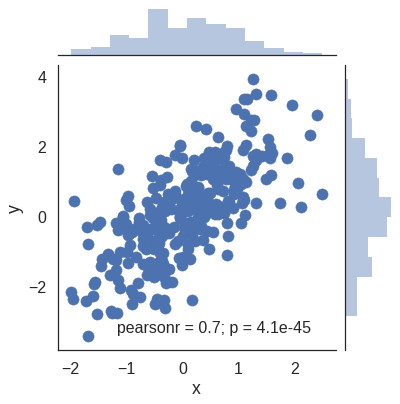

In [0]:
import pandas as pd
from matplotlib import pylab as plt
import seaborn as sns

sns.set_context('poster')
sns.set_style('white')

def plot_joint(model, num_samples, x, y, **kwargs):
  samples = [sample_from_model(model) for _ in range(num_samples)]
  sns.jointplot(data=pd.DataFrame(samples), x=x, y=y, **kwargs)
  
plot_joint(model1, 300, 'x', 'y')

##Interventions

One of the key concepts in causal inference is the concept of an intervention: what happens if I set the a certain variable  a certain value. Using SEMs, one can simulate a world where this intervention takes place by replacing the equation that naturally instantiates the variable in question with a function that always returns a constant. This is often called `mutilation` because this operation corresponds to removing all edges leading to the intervened-on variables in the causal diagram representation of the SEM.

Let's write a function that takes a model, and a list of interventions and outputs the mutilated structural equation model:

In [0]:
def intervene(model, **interventions):
  """Modifies a structural equation model to simulate the effect of intervening
    on the value of a variable.
  
    Parameters
    ----------
    model
        A structural equation model encoded as an ordered dictionary mapping
        variable names to the functions used to instantiate them
    interventions
        Further keyword arguments specifying interventions.
        
    Example
    -------
    
    >>> model = OrderedDict ([
         ('x', lambda epsilon, **kwargs: epsilon[0]),
         ('y', lambda epsilon, x, **kwargs: x + epsilon[1]),
        ])

    >>> mutilated = intervene(model, x=1)
        
    Returns
    -------
    dict
        A dictionary that encodes the mutilated SEM describing the intervention
        scenario. Keys are variable names, values are functions that instantiate
        the variables based on causal parents and exogeneous noise variables.
  """
  new_model = model.copy()
  for variable, value in interventions.items():
    new_model[variable] = lambda epsilon, **kwargs : value
  return new_model

Let's look at how this function works. We start by copying the original model. For each keyword argument like `x=1` describing an intervention, we are going to have a key, value pair like `x:1`  in the interventions dictionary. The function walks down this list of interventions and overrides the function instantiating the variable in question by a dummy function that sets the variable to a certain value, ignoring the noise variables `epsilon` and all causal parents.

Let's use this in conjunction with our sampling and plotting functions.

In [0]:
#expected {'x': 1, 'y': 1.8214553545920231}
np.random.seed(seed=2019)
sample_from_model(intervene(model1, x=1))

{'x': 1, 'y': 1.8214553545920231}

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


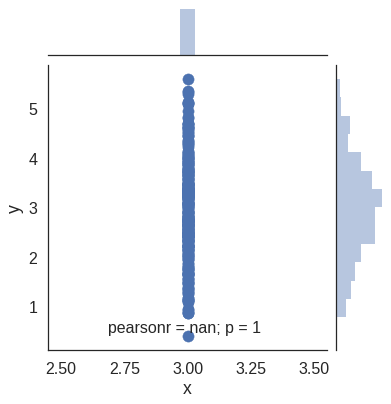

In [0]:
plot_joint(intervene(model1, x=3), 300, x='x', y='y')

We can see that, as expected, after intervening on $x$ we can only ever sample values where the value of $x$ is fixed to $1$. In do-calculus notation, the marginal distribution of $y$, shown by the histogram on the right-hand-side, is denoted $p(x\vert do(x=1))$.

## Exercise 2

To test your understanding so far, try reimplementing the intervene function. Below I provided a test that should pass if your implementation is correct.

In [0]:
def test_intervene():
  """tests if intervene does what it is supposed to."""
  np.random.seed(seed=2019)
  test_model = OrderedDict ([
    ('x', lambda epsilon, **kwargs: epsilon[0]),
    ('y', lambda epsilon, x, **kwargs: x + epsilon[1]),
  ])
  mutilatedx = intervene(test_model, x=1)
  mutilatedy = intervene(test_model, y=1)
  mutilatedxy = intervene(test_model, x=1, y=1)
  
  np.random.seed(seed=2019)
  sample = sample_from_model(test_model)
  assert 'x' in sample.keys()
  assert 'y' in sample.keys()
  np.testing.assert_equal(sample['x'], -0.21767896374028844)
  np.testing.assert_equal(sample['y'], 0.6037763908517348)
  
  np.random.seed(seed=2019)
  sample = sample_from_model(mutilatedx)
  assert 'x' in sample.keys()
  assert 'y' in sample.keys()
  np.testing.assert_equal(sample['x'], 1)
  np.testing.assert_equal(sample['y'], 1.8214553545920231)
  
  np.random.seed(seed=2019)
  sample = sample_from_model(mutilatedy)
  assert 'x' in sample.keys()
  assert 'y' in sample.keys()
  np.testing.assert_equal(sample['x'], -0.21767896374028844)
  np.testing.assert_equal(sample['y'], 1)
  
  np.random.seed(seed=2019)
  sample = sample_from_model(mutilatedxy)
  assert 'x' in sample.keys()
  assert 'y' in sample.keys()
  np.testing.assert_equal(sample['x'], 1)
  np.testing.assert_equal(sample['y'], 1)

In [0]:
test_intervene()
print('Test passes.')

Test passes.


## More plotting

Let's create some more interesting plotting functions. Ones that plot the
* marginal distribution $p(y)$ of samples from a model
* the conditional distribution $p(y\vert x)$ of one variable based on another in a model
* the intervention-conditional $p(y\vert do(x))$, i.e. the marginal distribution of one variable in the mutilated model where another variable is intervened on

In [0]:
def plot_marginal(model, variable, num_samples=2000):
    samples = [sample_from_model(model) for _ in range(num_samples)]
    sns.kdeplot(pd.DataFrame(samples)[variable])
    
def plot_conditional(model, target_variable, given_variable, value, num_samples=1000000, tol=0.1):
    samples = [sample_from_model(model) for _ in range(num_samples)]
    samples = pd.DataFrame(samples)
    filtered = samples[samples[given_variable].apply(lambda x: (x - value)**2 < tol**2)]
    sns.kdeplot( filtered[target_variable])
    
def plot_intervention_conditional(model, target_variable, given_variable, value, num_samples=100000, tol=0.1):
    samples = [sample_from_model(intervene(model, **{given_variable:value})) for _ in range(num_samples)]
    samples = pd.DataFrame(samples)
    filtered = samples[samples[given_variable].apply(lambda x: (x - value)**2 < tol**2)]
    sns.kdeplot( filtered[target_variable])

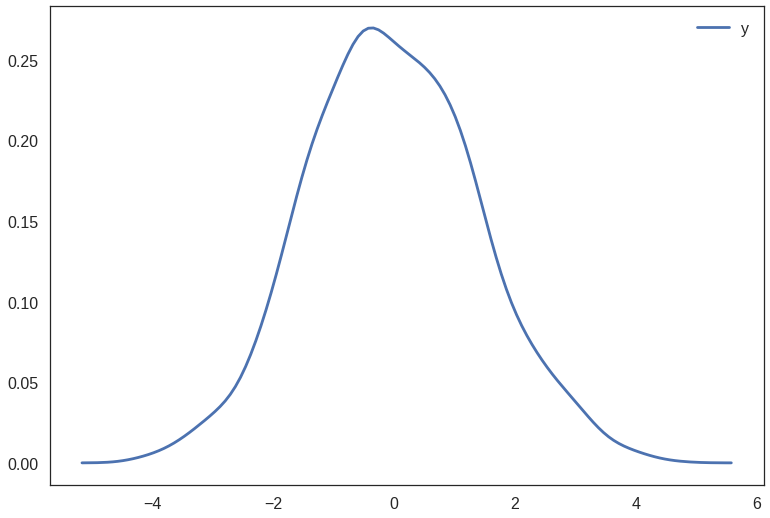

In [0]:
plot_marginal(model1, 'y')

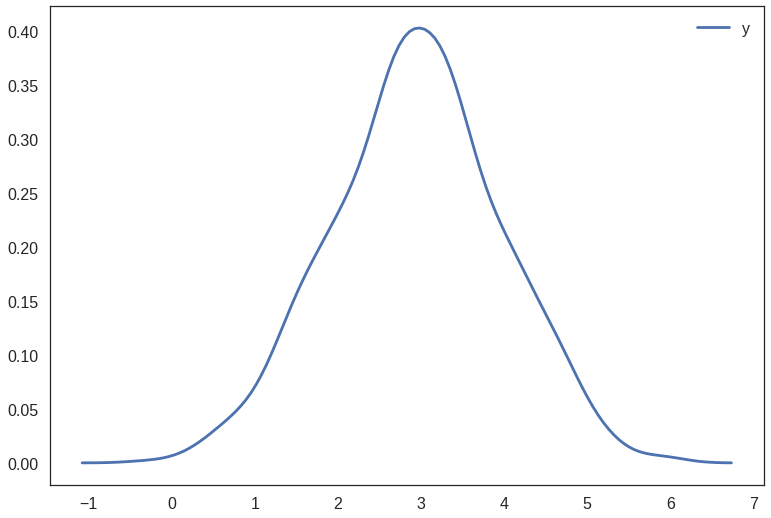

In [0]:
plot_conditional(model1, 'y', 'x', 3)

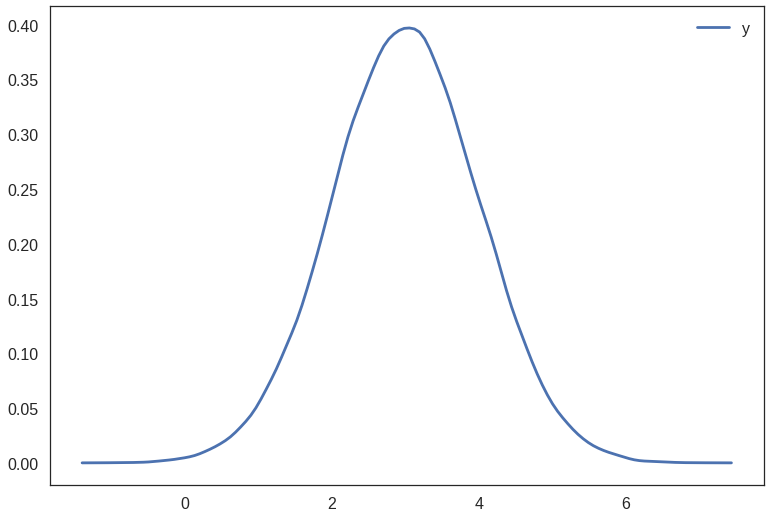

In [0]:
plot_intervention_conditional(model1, 'y', 'x', 3)

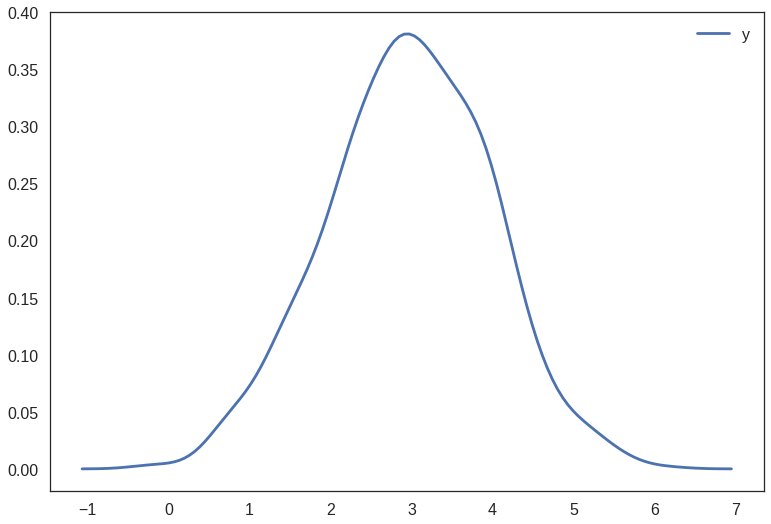

In [0]:
plot_conditional(model1, 'y', 'x', 3)

##Three scripts toy example

Here is my three scripts toy example from the tutorial which I also wrote up in [this blog post](https://www.inference.vc/causal-inference-2-illustrating-interventions-in-a-toy-example/). All three scripts - encoded here as structural equation models -  produce the same joint distribution over $x$ and $y$, but they have different causal structure:

In [0]:
#x --> y
model_xy = OrderedDict ([
  ('x', lambda epsilon, **kwargs: epsilon[0]),
  ('y', lambda epsilon, x, **kwargs: x + 1 + np.sqrt(3)*epsilon[1])
])

In [0]:
#y --> x
model_yx = OrderedDict ([
  ('y', lambda epsilon, **kwargs: 1 + 2*epsilon[0]),
  ('x', lambda epsilon, y, **kwargs: 0.25*(y-1) + np.sqrt(0.75)*epsilon[1])
])

In [0]:
#y <-- z --> x
model_conf = OrderedDict ([
  ('z', lambda epsilon, **kwargs: epsilon[0]),
  ('x', lambda epsilon, z, **kwargs: z),
  ('y', lambda epsilon, z, **kwargs: z + 1 + np.sqrt(3)*epsilon[1])
])

###Statistical properties: Marginals and Conditionals

In this section, we'll verify that the three scripts indeed produce the same joint distribution, and that they are therefore indistinguishable in terms of the statistical properties of the samples they produce.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


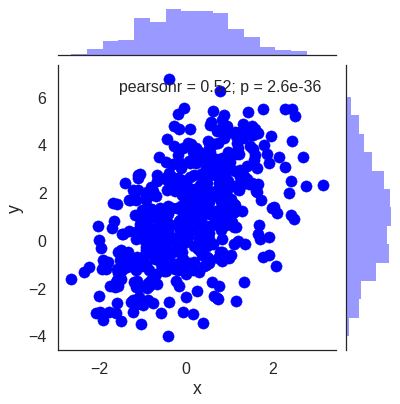

In [0]:
plot_joint(model_xy, 500, 'x', 'y', color="b")

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


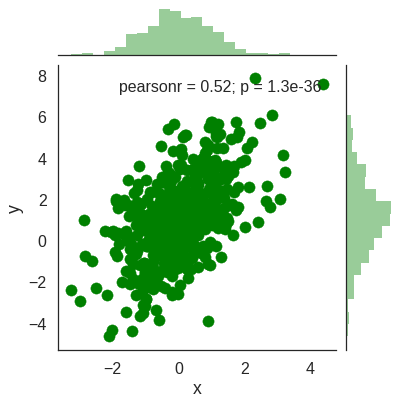

In [0]:
plot_joint(model_yx, 500, 'x', 'y', color="g")

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


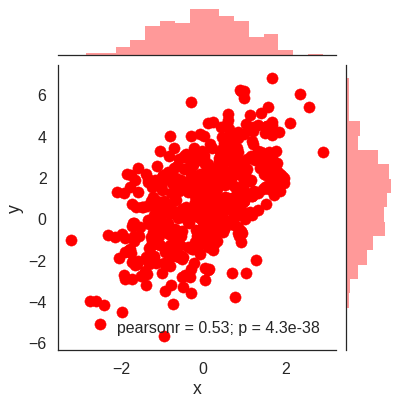

In [0]:
plot_joint(model_conf, 500, 'x', 'y', color='r')

Since the three models specify the same joint distribution over $x$ and $y$, any conditional distributions would also be indistinguishable under the three models. For example, here is $p(y\vert x=3)$ for the three models:

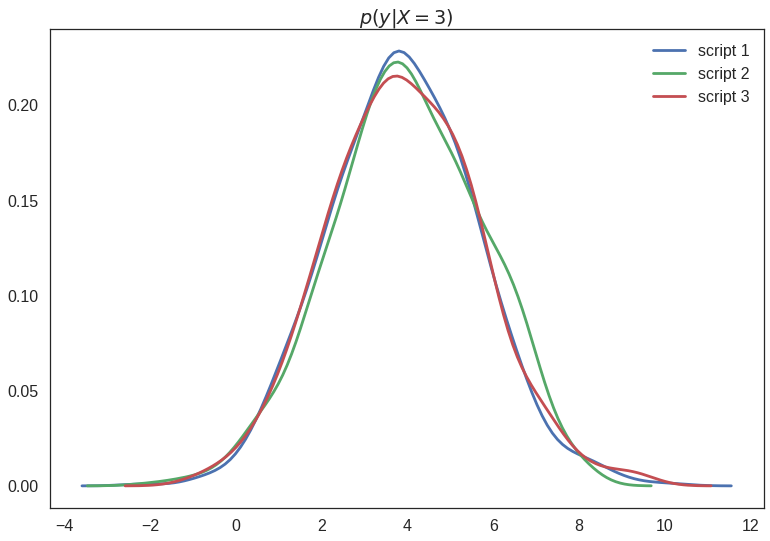

In [0]:
plot_conditional(model_xy, 'y', 'x', 3)
plot_conditional(model_yx, 'y', 'x', 3)
plot_conditional(model_conf, 'y', 'x', 3)
plt.legend(['script 1', 'script 2', 'script 3'])
plt.title('$p(y\\vert X=3)$');

We can even run various statistical tests to verify that the samples are indeed follow the same distribution. Here, I simply test that the first two models have the same mean:

In [0]:
from scipy.stats import ttest_ind

N=1000

samples1 = pd.DataFrame([sample_from_model(model_xy) for _ in range(N)])
samples2 = pd.DataFrame([sample_from_model(model_yx) for _ in range(N)])

ttest_ind(samples1, samples2)

Ttest_indResult(statistic=array([1.04788341, 2.55586553]), pvalue=array([0.29481907, 0.01066583]))

### Simulating behaviour under interventions

Now let's see how these models behave under intervention. Using our handy `intervention` function we can actually simulate interventions, and plot the statistical properties of samples in this condition:

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


(-8, 8)

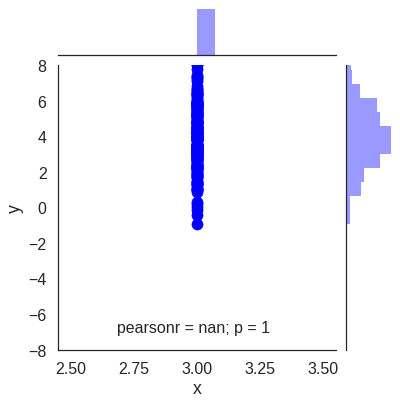

In [0]:
plot_joint(intervene(model_xy, x=3), 200, 'x', 'y', color='b')
plt.ylim([-8,8])

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


(-8, 8)

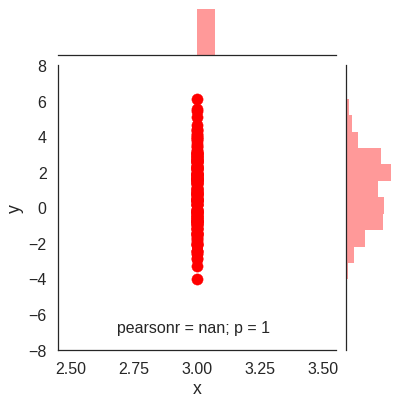

In [0]:
plot_joint(intervene(model_yx, x=3), 200, 'x', 'y', color='r')
plt.ylim([-8,8])

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


(-8, 8)

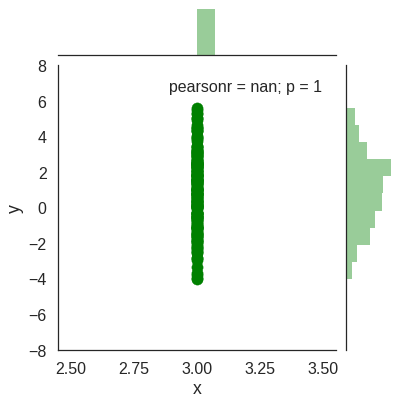

In [0]:
plot_joint(intervene(model_conf, x=3), 200, 'x', 'y', color='g')
plt.ylim([-8,8])

Text(0.5, 1.0, '$p(y\\vert do(X=3))$ obtained by simulating intervention')

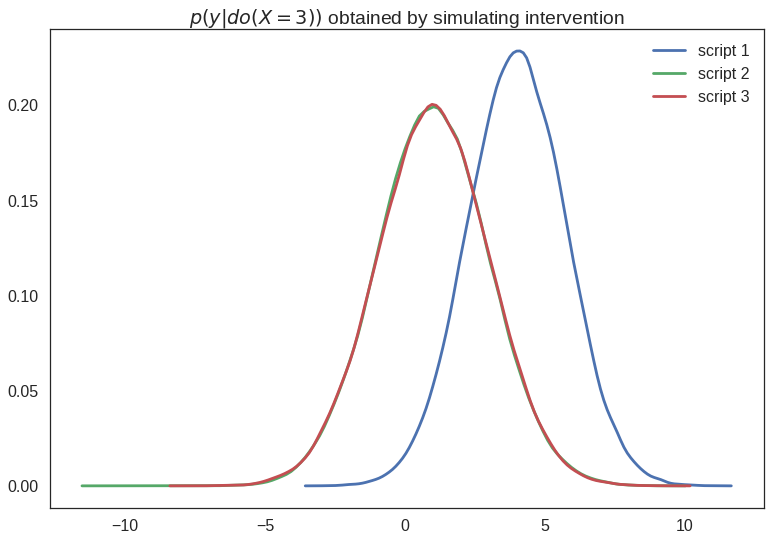

In [0]:
plot_intervention_conditional(model_xy, 'y', 'x', 3)
plot_intervention_conditional(model_yx, 'y', 'x', 3)
plot_intervention_conditional(model_conf, 'y', 'x', 3)
plt.legend(['script 1', 'script 2', 'script 3'])
plt.title('$p(y\\vert do(X=3))$ obtained by simulating intervention')

We can see that the three models do not behave identically under intervention. In particular, the blue model, `model1`, behaves differently from the other two. An this difference is very important because:

> Since the three models are indistinguishable based on the joint distribution of data they generate, this difference could not have been predicted based on the joint distribution alone.

### Predicting behaviour under interventions using causal inference

While the joint distribution is not sufficient to predict the different behaviour of the three models under intervention, we can start making such predictions, if we complement our analysis with the causal diagram corresponding to the three models.

The three models are described by different causal graps:
* `model_xy` can be described as $x \rightarrow y$. In this causal graph, do calculus allows us to predict that under intervention, the distribution of $y$, $p(y\vert do(x=3))$ will be the same as $p(y|x)$.
* `model_yx` is described by the causal graph $y\rightarrow x$. Using do calculus logic, we can see that after intervening on $x$, $y$ and $x$ become independent, and therefore $p(y\vert do(x=3)) = p(y)$.
* `model_conf` is described as $y \leftarrow z \rightarrow x$. Similarly to `model2`,  $p(y\vert do(x=3)) = p(y)$ holds in this model also.

Therefore, we can plot  $p(y\vert do(x=3))$ for the three models without ever having to explicitly call the `intervene` function. In other words, do calculus allowed us to reason about what happens under intervention, without ever having to directly observe data from the intervention scenario (i.e. carry out an experiment).

Text(0.5, 1.0, '$p(y\\vert do(X=3))$ estimated via causal inference')

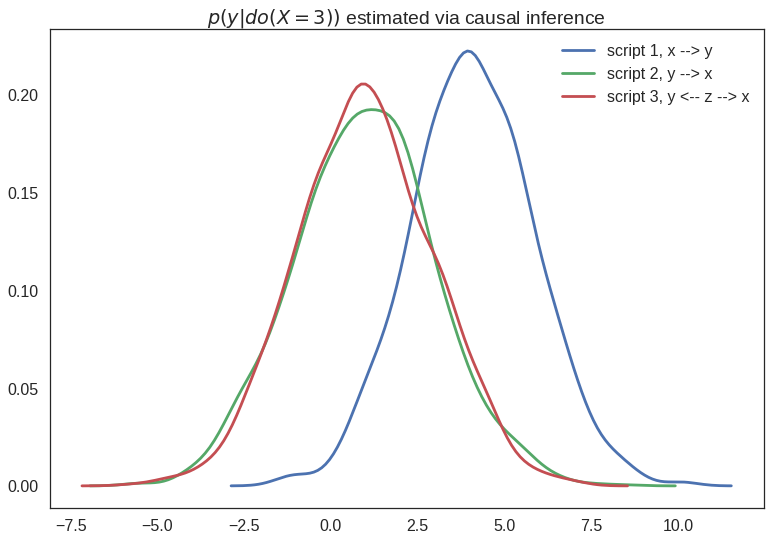

In [0]:
plot_conditional(model_xy, 'y', 'x', 3)
plot_marginal(model_yx, 'y')
plot_marginal(model_conf, 'y')
plt.legend(['script 1, x --> y', 'script 2, y --> x', 'script 3, y <-- z --> x'])
plt.title('$p(y\\vert do(X=3))$ estimated via causal inference')

## Counterfactuals

The mini-framework in this tutorial allows us to simulate counterfactuals as well. I explained counterfactuals in [this blog post](https://www.inference.vc/causal-inference-3-counterfactuals/). Below is a function that takes a SEM, draws both a sample and the correspoiding counterfactual sample under certain interventions:


In [0]:
def sample_counterfactuals(model, epsilon=None, **interventions):
  """Produces a single sample from a structural equation model, and the
    corresponding counterfactual sample under a set of interventions.
  
    If the specific values of exogeneous variables `epsilon` are not provided,
    they are drawn from a normal distribution and hence, a random sample is
    produced. You can also specify `epsilon` if you want finer control over the
    random seed.
  
    Parameters
    ----------
    model
        A structural equation model encoded as an ordered dictionary mapping
        variable names to the functions used to instantiate them
    epsilon
        An optional parameter specifying the value of the exogeneous/noise
        variables used in the structural equations. If not specified, random
        Gaussian noise will be used.
    interventions
        Additional keyword arguments specify the interventions in the
        counterfactual situation.
        
    Returns
    -------
    dict
        A dictionary mapping variable names to the values computed using the 
        SEM. For each variable in the original model, there is a corresponding
        counterfactual variable with a `*` appended to its name.
        
        
    Examples
    --------
    
    >>> model = OrderedDict ([
         ('x', lambda epsilon, **kwargs: epsilon[0]),
         ('y', lambda epsilon, x, **kwargs: x + epsilon[1]),
        ])

    >>> sample_counterfactuals(model, x=3)
    {'x': 1.0103741924037875,
     'x*': 1,
     'y': -0.5274538614081545,
     'y*': -0.5378280538119422}
    
  """
  mutilated_model = intervene(model, **interventions)
  if epsilon is None:
     epsilon = randn(len(model))
  factual_sample = sample_from_model(model, epsilon)
  counterfactual_sample = sample_from_model(mutilated_model, epsilon)
  #renaming variables
  counterfactual_sample = dict((key+'*', value) for key, value in counterfactual_sample.items())
  return {**factual_sample, **counterfactual_sample}

In [0]:
#draw some samples with a fixed seed
np.random.seed(seed=2019)
print ('first sample:')
print (sample_counterfactuals(model1, x=3))
print ('second sample:')
print (sample_counterfactuals(model1, x=3))

first sample:
{'x': -0.21767896374028844, 'y': 0.6037763908517348, 'x*': 3, 'y*': 3.821455354592023}
second sample:
{'x': 1.4812778090390923, 'y': 2.8131418512703092, 'x*': 3, 'y*': 4.331864042231217}


##Exercise 3

To test your understadning so far, try reimplementing the `sample_counterfactuals` function. Below, I provide a test that should pass if you successfully implemented it. 

In [0]:
def test_sample_counterfactuals():
  """tests if sample_counterfactuals does what it is supposed to."""
  test_model = OrderedDict ([
    ('x', lambda epsilon, **kwargs: epsilon[0]),
    ('y', lambda epsilon, x, **kwargs: x + epsilon[1]),
  ])
   
  np.random.seed(seed=2019)
  sample = sample_counterfactuals(model1, x=3)
  np.testing.assert_equal(sample['x'], -0.21767896374028844)
  np.testing.assert_equal(sample['y'], 0.6037763908517348)
  np.testing.assert_equal(sample['x*'], 3)
  np.testing.assert_equal(sample['y*'], 3.821455354592023)
  
  #this bit tests that the function doesn't have a side effect on the model:
  np.random.seed(seed=2019)
  sample = sample_from_model(test_model)
  assert 'x' in sample.keys()
  assert 'y' in sample.keys()
  np.testing.assert_equal(sample['x'], -0.21767896374028844)
  np.testing.assert_equal(sample['y'], 0.6037763908517348)
  
  
  

In [0]:
test_sample_counterfactuals()
print('Test passed.')

Test passed.


### Playing with counterfactuals in the simple model

As we sample counterfactual and factual variables, we use the same set of noise variables $\epsilon$ in both the original and the mutilated SEM. This intriduces dependency between variables in the observable data, say $y$ and variables in the counterfactual world $y^\ast$ which we can't directly observe. Below, I will illustrate this dependence by plotting the joint distribution of a couple variables:**bold text**

In [0]:
import pandas as pd

counterfactual_df = pd.DataFrame([sample_counterfactuals(model_xy, x=1) for _ in range(100)])
counterfactual_df.head()

,x,x*,y,y*
0,1.481278,1,4.788134,4.306856
1,-0.361865,1,1.825644,3.187509
2,0.573761,1,2.072120,2.498359
3,-0.235634,1,2.415859,3.651494
4,-1.689625,1,-1.287084,1.402542


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


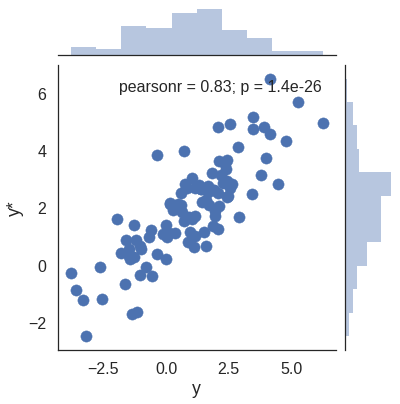

In [0]:
sns.jointplot(data=counterfactual_df, x='y', y='y*');

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


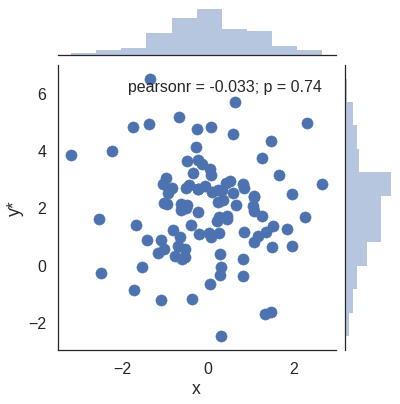

In [0]:
sns.jointplot(data=counterfactual_df, x='x', y='y*');

### Predicting the value of the counterfactual variables

If we know the structural equation model, we can predict the value that the counterfactual variable $y^\ast$ takes from the value of the observed $x$ and $y$. In this case, because our SEM is linear and very simple, we can in fact predict $y^\ast$ perfectly using the formula $y^\ast = y - x + 3$.  

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


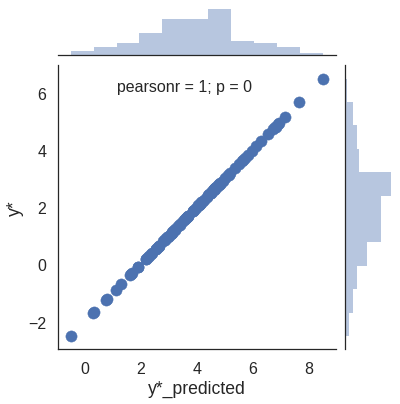

In [0]:
counterfactual_df['y*_predicted'] = counterfactual_df['y'] - counterfactual_df['x'] + 3

sns.jointplot(data=counterfactual_df, x='y*_predicted', y='y*');